## OCR (Optical Character Recognition)

### Import dependecies

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

### Preprocess dataset

In [8]:
# Define the path to the folder containing the dataset
dataset_path = "dataset/"

# Function to load and preprocess the dataset
def load_dataset(dataset_path):
    images = []
    labels = []
    options = ["A", "B", "C", "D", "E"]
    
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image_resized = cv2.resize(image, (72, 15))
                images.append(image_resized)
                label = np.zeros(len(options))
                label[options.index(folder)] = 1
                labels.append(label)
    
    return np.array(images), np.array(labels)

### Define CNN model

In [4]:
# Load and preprocess the dataset
X, y = load_dataset(dataset_path)

# Normalize pixel values to the range [0, 1]
X = X.astype(np.float32) / 255.0

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(15, 72, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 classes: A, B, C, D, E
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 70, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 35, 32)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6720)              0         
                                                                 
 dense (Dense)               (None, 128)               860288    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 861,253
Trainable params: 861,253
Non-trainable params: 0
__________________________________________________

### Train the model

In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model and save the fitting history
history = model.fit(X_train.reshape(-1, 15, 72, 1), y_train, epochs=10, batch_size=16, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test.reshape(-1, 15, 72, 1), y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Save the trained model
model_dir = "model/"
os.makedirs(model_dir, exist_ok=True)
model.save(os.path.join(model_dir, "answer_sheet_reader_model.h5"))

Epoch 1/10
20/20 [==============================] - 3s 68ms/step - loss: 1.2545 - accuracy: 0.6719 - val_loss: 0.6738 - val_accuracy: 1.0000
Epoch 2/10
20/20 [==============================] - 1s 37ms/step - loss: 0.3150 - accuracy: 1.0000 - val_loss: 0.0984 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 1s 40ms/step - loss: 0.0443 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 1s 42ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 1s 43ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 1s 51ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 1s 40ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 8/10
20

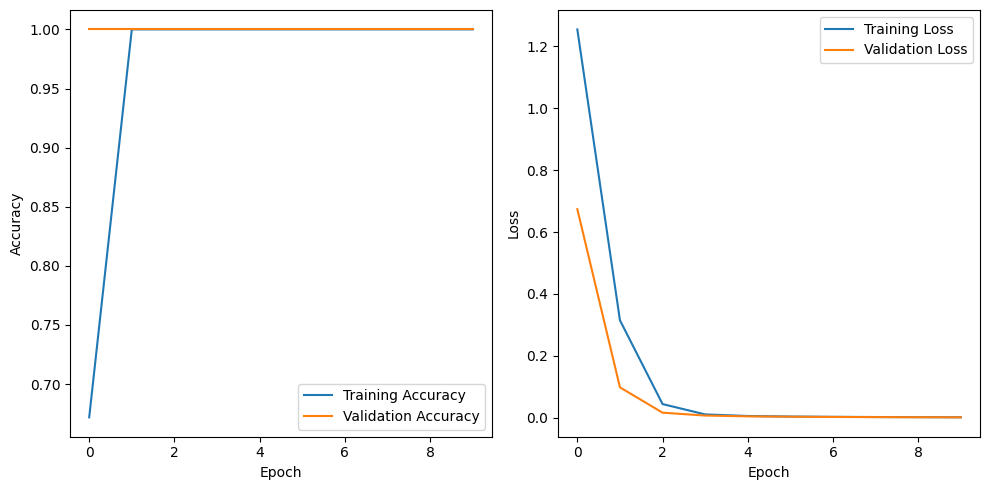

In [7]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Testing the model

In [9]:
# Function to preprocess the test image
def preprocess_test_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, (72, 15))
    image_normalized = image_resized.astype(np.float32) / 255.0
    return image_normalized.reshape(1, 15, 72, 1)  # Add a batch dimension

In [10]:
# Load the trained model
model_dir = "model/"
model_path = os.path.join(model_dir, "answer_sheet_reader_model.h5")
model = models.load_model(model_path)

In [11]:
# Load and preprocess the test image
test_image_path = "testing/A1.jpeg"
test_image = preprocess_test_image(test_image_path)

# Make predictions
predictions = model.predict(test_image)

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Map the predicted class index to the corresponding option (A, B, C, D, E)
options = ["A", "B", "C", "D", "E"]
predicted_option = options[predicted_class_index]

print(f"Predicted Answer: {predicted_option}")

1/1 [==============================] - 0s 358ms/step
Predicted Answer: A


In [16]:
# Load the answer sheet image
answer_sheet_path = "testing/Test1.jpeg"
answer_sheet = cv2.imread(answer_sheet_path, cv2.IMREAD_GRAYSCALE)

# Define the bounding box coordinates for each row in the first column (10 questions)
first_column_coordinates = [
    ((17, 7), (86, 19)),
    *[((17, 7 + (i*15)), (86, 19 + (i*15))) for i in range(1, 10)]
]

# Define the bounding box coordinates for each row in the second column (10 questions)
second_column_coordinates = [
    ((120, 7), (191, 19)),
    *[((120, 7 + (i*15)), (191, 19 + (i*15))) for i in range(1, 10)]
]

# Function to save the extracted answer image with the format "question_number.jpeg"
def save_answer_image(image, question_number, output_folder):
    answer_image_path = os.path.join(output_folder, f"{question_number}.jpeg")
    cv2.imwrite(answer_image_path, image)

# Extract and save the answers for the first column (questions 1 to 10)
output_folder = "parsed/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i, coords in enumerate(first_column_coordinates, 1):
    (x1, y1), (x2, y2) = coords
    print(f"Extracting row {i} from first column - Coordinates: {(x1, y1)}, {(x2, y2)}")
    row_image = answer_sheet[y1:y2, x1:x2]
    if row_image.size == 0:
        print("Empty image data. Check the coordinates.")
    else:
        save_answer_image(row_image, i, output_folder)

# Extract and save the answers for the second column (questions 11 to 20)
for i, coords in enumerate(second_column_coordinates, 11):
    (x1, y1), (x2, y2) = coords
    print(f"Extracting row {i} from second column - Coordinates: {(x1, y1)}, {(x2, y2)}")
    row_image = answer_sheet[y1:y2, x1:x2]
    if row_image.size == 0:
        print("Empty image data. Check the coordinates.")
    else:
        save_answer_image(row_image, i, output_folder)

Extracting row 1 from first column - Coordinates: (17, 7), (86, 19)
Extracting row 2 from first column - Coordinates: (17, 22), (86, 34)
Extracting row 3 from first column - Coordinates: (17, 37), (86, 49)
Extracting row 4 from first column - Coordinates: (17, 52), (86, 64)
Extracting row 5 from first column - Coordinates: (17, 67), (86, 79)
Extracting row 6 from first column - Coordinates: (17, 82), (86, 94)
Extracting row 7 from first column - Coordinates: (17, 97), (86, 109)
Extracting row 8 from first column - Coordinates: (17, 112), (86, 124)
Extracting row 9 from first column - Coordinates: (17, 127), (86, 139)
Extracting row 10 from first column - Coordinates: (17, 142), (86, 154)
Extracting row 11 from second column - Coordinates: (120, 7), (191, 19)
Extracting row 12 from second column - Coordinates: (120, 22), (191, 34)
Extracting row 13 from second column - Coordinates: (120, 37), (191, 49)
Extracting row 14 from second column - Coordinates: (120, 52), (191, 64)
Extracting r

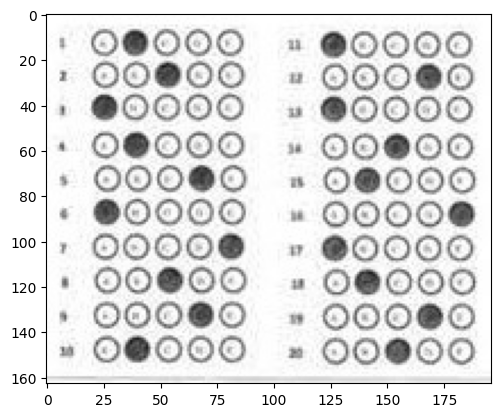

1/1 [==============================] - 0s 57ms/step
Question 1: Predicted Answer: B
1/1 [==============================] - 0s 76ms/step
Question 2: Predicted Answer: C
1/1 [==============================] - 0s 51ms/step
Question 3: Predicted Answer: A
1/1 [==============================] - 0s 55ms/step
Question 4: Predicted Answer: B
1/1 [==============================] - 0s 73ms/step
Question 5: Predicted Answer: D
1/1 [==============================] - 0s 52ms/step
Question 6: Predicted Answer: A
1/1 [==============================] - 0s 139ms/step
Question 7: Predicted Answer: E
1/1 [==============================] - 0s 117ms/step
Question 8: Predicted Answer: C
1/1 [==============================] - 0s 43ms/step
Question 9: Predicted Answer: D
1/1 [==============================] - 0s 47ms/step
Question 10: Predicted Answer: B
1/1 [==============================] - 0s 47ms/step
Question 11: Predicted Answer: A
1/1 [==============================] - 0s 60ms/step
Question 12: Predict

In [17]:
# Load and preprocess the test images from the "parsed/" folder
input_folder = "parsed/"
num_questions = 20

img = cv2.imread(answer_sheet_path)
plt.imshow(img)
plt.show()

for i in range(1, num_questions + 1):
    # Load the test image
    test_image_path = os.path.join(input_folder, f"{i}.jpeg")
    test_image = preprocess_test_image(test_image_path)

    # Make predictions
    predictions = model.predict(test_image)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(predictions)

    # Map the predicted class index to the corresponding option (A, B, C, D, E)
    options = ["A", "B", "C", "D", "E"]
    predicted_option = options[predicted_class_index]

    print(f"Question {i}: Predicted Answer: {predicted_option}")